In [56]:
# Basic Init
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import os
from sqlalchemy import func
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt


In [34]:
# Create an engine to connect to the SQLite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# Use automap_base() to reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

# Check the reflected tables
print(Base.classes.keys())

# Save references to the 'station' and 'measurement' tables
Station = Base.classes.station
Measurement = Base.classes.measurement

['measurement', 'station']


C:\Users\jakef\AppData\Local\Temp\ipykernel_38656\2054316523.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [38]:
# Create a session to link Python to the database
session = Session(engine)

In [40]:
# Verify functionality
stations = session.query(Station).all()
print(f"Total Stations: {len(stations)}")

# Query the first row from the Measurement table
first_measurement = session.query(Measurement).first()
print(f"First Measurement: {first_measurement.__dict__}")

Total Stations: 9
First Measurement: {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000022C2206E570>, 'prcp': 0.08, 'tobs': 65.0, 'date': '2010-01-01', 'id': 1, 'station': 'USC00519397'}


In [46]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date: {most_recent_date}")

Most Recent Date: 2017-08-23


In [50]:
# Calculate the date 12 months ago
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query precipitation data for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

In [54]:
# Load results into a Pandas DataFrame
precipitation_df = pd.DataFrame(results, columns=["date", "prcp"])

# Drop rows with missing values
precipitation_df = precipitation_df.dropna()

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by="date")

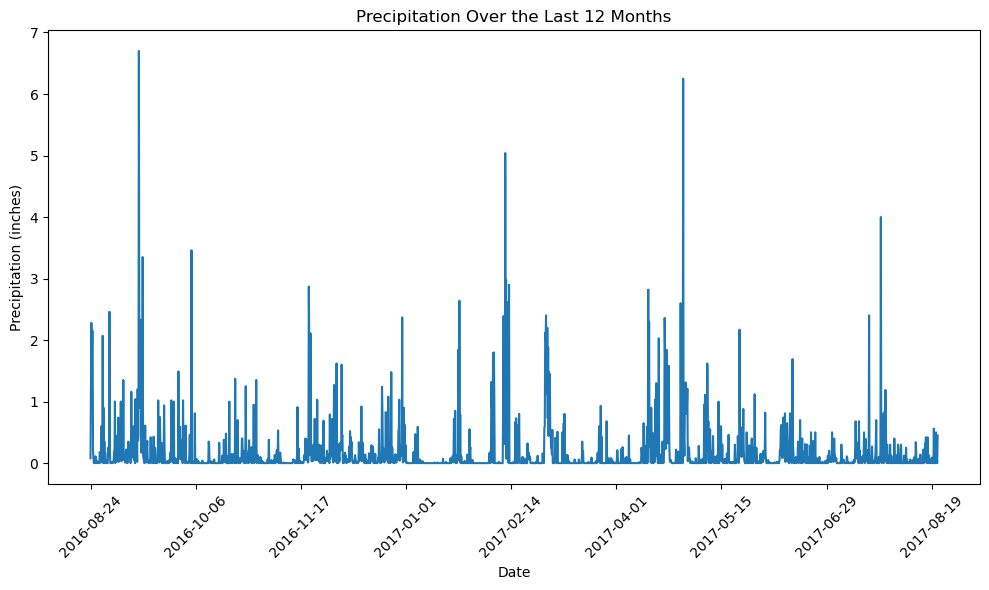

In [57]:
# Plot the data
precipitation_df.plot(x="date", y="prcp", figsize=(10, 6), legend=False)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total Number of Stations: {total_stations}")

Total Number of Stations: 9


In [62]:
# Query to find the most-active stations
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label("observation_count"))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Observations: {count}")

# Find the station ID with the greatest number of observations
most_active_station_id = most_active_stations[0][0]
print(f"Most-Active Station ID: {most_active_station_id}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511
Most-Active Station ID: USC00519281


In [64]:
# Query to calculate temperature stats for the most-active station
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label("min_temp"),
        func.max(Measurement.tobs).label("max_temp"),
        func.avg(Measurement.tobs).label("avg_temp")
    )
    .filter(Measurement.station == most_active_station_id)
    .one()
)

# Extract results
min_temp = temperature_stats.min_temp
max_temp = temperature_stats.max_temp
avg_temp = temperature_stats.avg_temp

print(f"Temperature Stats for Station {most_active_station_id}:")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.1f}°F")

Temperature Stats for Station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.7°F


In [66]:
# Find the most-active station
most_active_station_id = (
    session.query(Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()[0]
)
print(f"Most-Active Station ID: {most_active_station_id}")

Most-Active Station ID: USC00519281


In [68]:
# Query the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date: {most_recent_date}")

Most Recent Date: 2017-08-23


In [70]:
# Calculate the date 12 months ago
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query the last 12 months of TOBS data for the most-active station
tobs_results = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert results to a flat list
tobs_data = [result[0] for result in tobs_results]

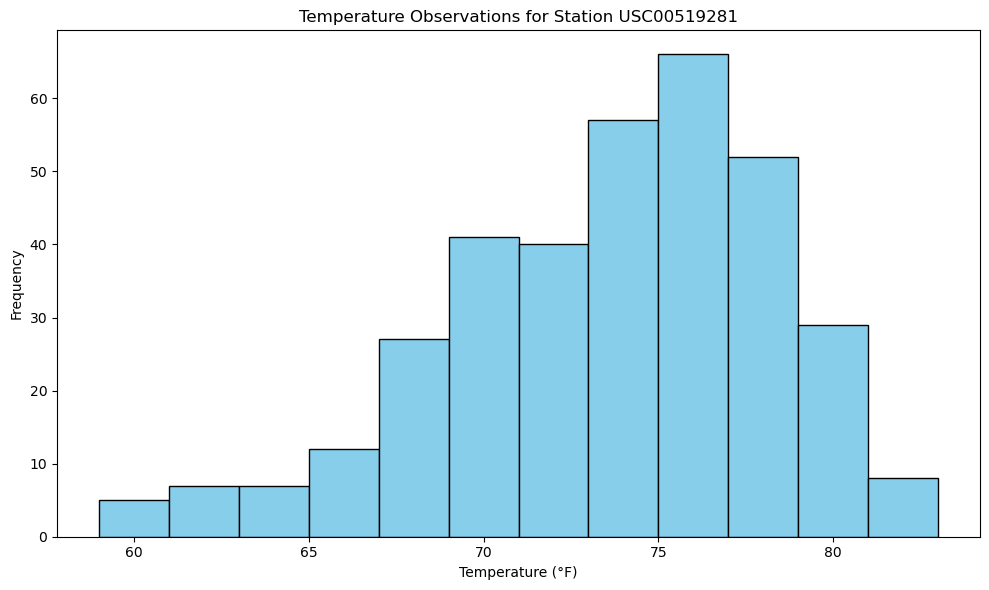

In [72]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(tobs_data, bins=12, color="skyblue", edgecolor="black")
plt.title(f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [74]:
# Close the session
session.close()